In [1]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
FIG_DIR, TAB_DIR = "../results/figures", "../results/tables"
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(TAB_DIR, exist_ok=True)


In [3]:

DATA_PATH = "/Users/sjsj/Documents/GitHub/final-project-repo-group8/data/raw/total_dataset.csv"
df = pd.read_csv(DATA_PATH, dtype=str, keep_default_na=False, low_memory=False)
df.head()


,AppName,Review ID,CustomerReplyContent,Score,Thumbsupcount,PlatformReply
0,Amazon shopping,a8bab7d7-d03a-4257-a922-15b0540c9e58,"I have to update my review on this company, th...",2,993,
1,Amazon shopping,0da41c37-6d79-451d-a665-b2797d3a5c2f,The Amazon App has suddenly stopped showing al...,2,990,
2,Amazon shopping,fddb6b4a-d73e-4aa9-b797-91d7d77d33e3,"I really hate the new AI feature (""Rufus""). Th...",2,99,
3,Amazon shopping,00f81af4-b723-430e-8636-732909c592f1,Wow the new design layout is so stupid! Now I ...,2,99,
4,Amazon shopping,ef5a4898-d90b-4218-83d8-a951b3018d73,Since one of the recent updates I can no longe...,1,99,


In [4]:
def basic_clean(s: str) -> str:
    s = re.sub(r"https?://\S+|www\.\S+", " ", s)      # URL
    s = re.sub(r"&(?:amp|nbsp|lt|gt);", " ", s)       # HTML 残留
    s = re.sub(r"[@#][A-Za-z0-9_]+", " ", s)          # @mention / #hashtag
    s = re.sub(r"[^A-Za-z0-9'\s]", " ", s)            # 非字母数字删掉（保留撇号）
    s = re.sub(r"\s+", " ", s).strip().lower()        # 挤空格 + 小写
    return s

df["text_clean"] = df["CustomerReplyContent"].apply(basic_clean)
df = df[df["text_clean"].astype(bool)].reset_index(drop=True)
df[["AppName","text_clean"]].head(3)

,AppName,text_clean
0,Amazon shopping,i have to update my review on this company the...
1,Amazon shopping,the amazon app has suddenly stopped showing al...
2,Amazon shopping,i really hate the new ai feature rufus the fac...


In [5]:
df["tokens"] = df["text_clean"].str.findall(r"[a-z0-9']+")

# 每条评论拆成多个 token 行
tok = (
    df[["AppName","tokens"]]
    .explode("tokens")
    .rename(columns={"tokens":"word"})
    .reset_index(drop=True)
)

tok.head(10)

,AppName,word
0,Amazon shopping,i
1,Amazon shopping,have
2,Amazon shopping,to
3,Amazon shopping,update
4,Amazon shopping,my
5,Amazon shopping,review
6,Amazon shopping,on
7,Amazon shopping,this
8,Amazon shopping,company
9,Amazon shopping,they


In [6]:
# 小而简的英语停用词（你可以继续往里加）
stop_small = {
    "a","an","the","and","or","of","to","in","for","on","with","at","by","from","as",
    "is","am","are","was","were","be","been","being",
    "it","this","that","these","those","i","me","my","we","our","you","your","he","she","they","them",
    "im","dont","ive","youre","hes","shes","theyre","cant","couldnt","didnt","doesnt","isnt","wasnt","werent",
    "just","so","too","very","also","but","if","not","not","now","then","there","here","when","where","why","how",
    "all","any","some","no","more","most","many","much","such",
    "what","which","who","whom","whose",
    "than","about","into","like","over","after","before","between","through","during","because","something",
    "have","has","had","having","do","does","did","doing"
}

# 评论里常见但信息量低的词（系统/操作/客套话等）
review_stop = {
    "use","using","update","updated","app","apps","version","android","iphone","ios","can","cannot","could","can't"
    "download","install","installed","login","account","please","thanks","thank","review"
    "bug","work","working","does","did","still","time","day","new","old","have","say","will","even"
}

# 平台名和泛词（避免占榜）
platform_stop = {
    "amazon","ebay","lazada","shein","get","got","also","one","two","really",
    "buy","bought","order","ordered","orders","product","item","it's"
}

ban = stop_small | review_stop | platform_stop

# 规则：长度≥3、包含字母或数字、且不在 ban 里
tok = tok[
    (tok["word"].str.len() >= 3) &
    (tok["word"].str.contains(r"[a-z0-9]")) &
    (~tok["word"].isin(ban))
].reset_index(drop=True)

tok.head(30)



,AppName,word
0,Amazon shopping,review
1,Amazon shopping,company
2,Amazon shopping,suck
3,Amazon shopping,can't
4,Amazon shopping,depend
5,Amazon shopping,supposed
6,Amazon shopping,delivered
7,Amazon shopping,same
8,Amazon shopping,delivery
9,Amazon shopping,don't


In [7]:
word_counts = (
    tok.groupby(["AppName","word"]).size()
      .reset_index(name="count")
      .sort_values(["AppName","count"], ascending=[True, False])
)

# 每个平台看前 10 行
word_counts.groupby("AppName").head(10)



,AppName,word,count
18386,Amazon shopping,love,11080
27193,Amazon shopping,shopping,10632
23320,Amazon shopping,prime,10601
26826,Amazon shopping,service,10451
14100,Amazon shopping,great,10071
5827,Amazon shopping,can't,9830
10127,Amazon shopping,don't,9616
9007,Amazon shopping,delivery,9234
16754,Amazon shopping,items,9183
13888,Amazon shopping,good,8713


In [8]:

TOPK = 15
top_words = word_counts.groupby("AppName").head(TOPK).reset_index(drop=True)

top_words.head(20)


,AppName,word,count
0,Amazon shopping,love,11080
1,Amazon shopping,shopping,10632
2,Amazon shopping,prime,10601
3,Amazon shopping,service,10451
4,Amazon shopping,great,10071
5,Amazon shopping,can't,9830
6,Amazon shopping,don't,9616
7,Amazon shopping,delivery,9234
8,Amazon shopping,items,9183
9,Amazon shopping,good,8713


In [9]:
TOPK = 50

word_counts_sorted = (
    word_counts.sort_values(["AppName","count"], ascending=[True, False])
)

top50_words = (
    word_counts_sorted.groupby("AppName", group_keys=False).head(TOPK)
    .reset_index(drop=True)
)

top50_words.head(10), top50_words.shape

(           AppName      word  count
 0  Amazon shopping      love  11080
 1  Amazon shopping  shopping  10632
 2  Amazon shopping     prime  10601
 3  Amazon shopping   service  10451
 4  Amazon shopping     great  10071
 5  Amazon shopping     can't   9830
 6  Amazon shopping     don't   9616
 7  Amazon shopping  delivery   9234
 8  Amazon shopping     items   9183
 9  Amazon shopping      good   8713,
 (200, 3))

In [10]:
TAB_DIR = TAB_DIR if "TAB_DIR" in globals() else "../results/tables"
os.makedirs(TAB_DIR, exist_ok=True)

out_path = f"{TAB_DIR}/top50_words_by_platform.csv"
top50_words.to_csv(out_path, index=False)
print("saved to:", out_path)

saved to: ../results/tables/top50_words_by_platform.csv


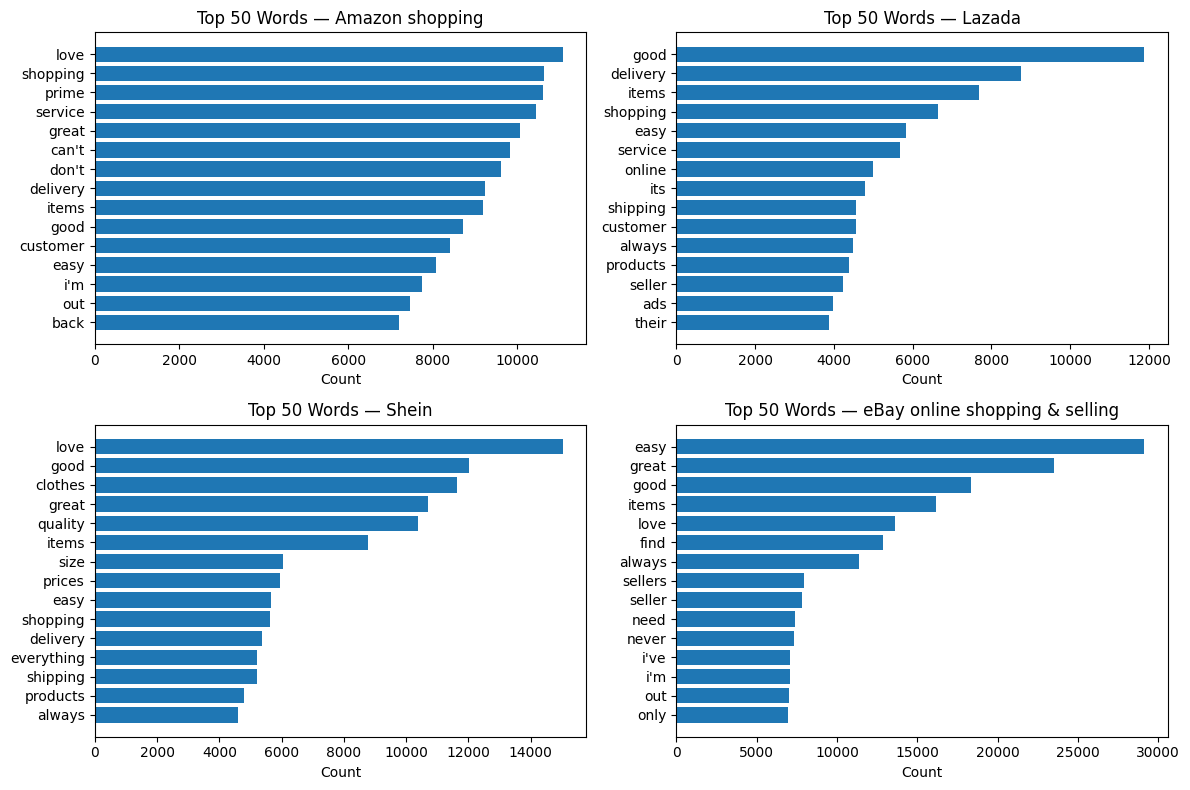

In [11]:
plats = top_words["AppName"].unique().tolist()
n = len(plats)
ncols = 2
nrows = (n + ncols - 1) // ncols

plt.figure(figsize=(12, 4*nrows))
for i, p in enumerate(plats, 1):
    sub = top_words[top_words["AppName"] == p].sort_values("count")
    plt.subplot(nrows, ncols, i)
    plt.barh(sub["word"], sub["count"])
    plt.title(f"Top {TOPK} Words — {p}")
    plt.xlabel("Count")
    plt.tight_layout()

plt.savefig(f"{FIG_DIR}/top_words_by_platform.png", dpi=300, bbox_inches="tight")
plt.show()


## TF-IDF Term Frequency – Inverse Document Frequency

In [16]:
# ① 评论里常见但信息量低的词（在 TF-IDF 前先排除）
generic_words = {
    # 评价类高频形容词/副词
    "good","great","nice","easy","best","better","amazing","awesome","bad","worst",
    "ok","okay","fine","cool","love","like","dislike",
    # 通用名词/动词
    "app","apps","product","products","item","items","thing","things","stuff",
    "customer","service","support","help","people","user","users",
    "shopping","shop","buy","bought","sell","seller","sellers",
    "use","using","used","work","working","does","did","done","make","made",
    "time","day","days","now","today","version",
    # 客套/连接词
    "please","thanks","thank","hi","hello","yes","no","also","still","really","very"
}

# ② 轻量“词形/同义词”标准化（够用就好）
normalize_map = {
    "refunds":"refund","refunded":"refund","refunding":"refund",
    "returns":"return","returned":"return","returning":"return",
    "deliveries":"delivery","delivered":"delivery","delivering":"delivery",
    "shipping":"ship","shipped":"ship","ships":"ship",
    "sizes":"sizing","sized":"sizing",
    "prices":"price","pricey":"price",
    "vouchers":"voucher","promos":"promo","promotions":"promo",
    "coupons":"coupon",
    "memberships":"membership","primevideo":"prime","primegaming":"prime",
    "auctions":"auction","bids":"bid","bidding":"bid"
}

def normalize_word(w: str) -> str:
    w = w.lower()
    if w in normalize_map: 
        return normalize_map[w]
    # 朴素单复数合并：长词尾部的 's' 去掉（避免把 'is' 之类短词误杀）
    if len(w) > 4 and w.endswith("s") and not w.endswith("ss"):
        return w[:-1]
    return w



In [17]:
# 你已有的 tok: ['AppName','word']（来自前面的分词 + 基本停用词过滤）
tok_refined = tok.copy()
tok_refined["word"] = tok_refined["word"].str.lower().map(normalize_word)

# 去掉“泛词”
tok_refined = tok_refined[~tok_refined["word"].isin(generic_words)]

# （可选）去非常罕见的词，减少噪声：全局出现次数 < 30 的忽略
min_count = 30
freq_all = tok_refined["word"].value_counts()
keep = set(freq_all[freq_all >= min_count].index)
tok_refined = tok_refined[tok_refined["word"].isin(keep)].reset_index(drop=True)

tok_refined.head(10)



,AppName,word
0,Amazon shopping,review
1,Amazon shopping,company
2,Amazon shopping,suck
3,Amazon shopping,can't
4,Amazon shopping,depend
5,Amazon shopping,supposed
6,Amazon shopping,delivery
7,Amazon shopping,same
8,Amazon shopping,delivery
9,Amazon shopping,don't


In [18]:
import numpy as np
import pandas as pd

# TF 的分子：某平台该词的出现次数
tf_count = (
    tok_refined.groupby(["AppName","word"])
               .size()
               .reset_index(name="count")
)

# TF 的分母：该平台全部 token 数
tokens_per_app = (
    tok_refined.groupby("AppName").size()
               .reset_index(name="total_tokens")
)

tf = tf_count.merge(tokens_per_app, on="AppName", how="left")
tf["tf"] = tf["count"] / tf["total_tokens"]

# DF：该词出现在多少个平台
platforms = tf["AppName"].nunique()
df_word = (tf.groupby("word")["AppName"].nunique()
             .reset_index(name="df_platforms"))

# IDF（平滑）
tfidf = tf.merge(df_word, on="word", how="left")
tfidf["idf"] = np.log((platforms + 1) / (tfidf["df_platforms"] + 1)) + 1
tfidf["tfidf"] = tfidf["tf"] * tfidf["idf"]

tfidf.head(5)



,AppName,word,count,total_tokens,tf,df_platforms,idf,tfidf
0,Amazon shopping,'add,19,1143275,0.000017,3,1.223144,0.000020
1,Amazon shopping,'cause,5,1143275,0.000004,4,1.000000,0.000004
2,Amazon shopping,'my,12,1143275,0.000010,3,1.223144,0.000013
3,Amazon shopping,000,108,1143275,0.000094,4,1.000000,0.000094
4,Amazon shopping,100,624,1143275,0.000546,4,1.000000,0.000546


saved: ../results/tables/top_tfidf_refined_by_platform.csv


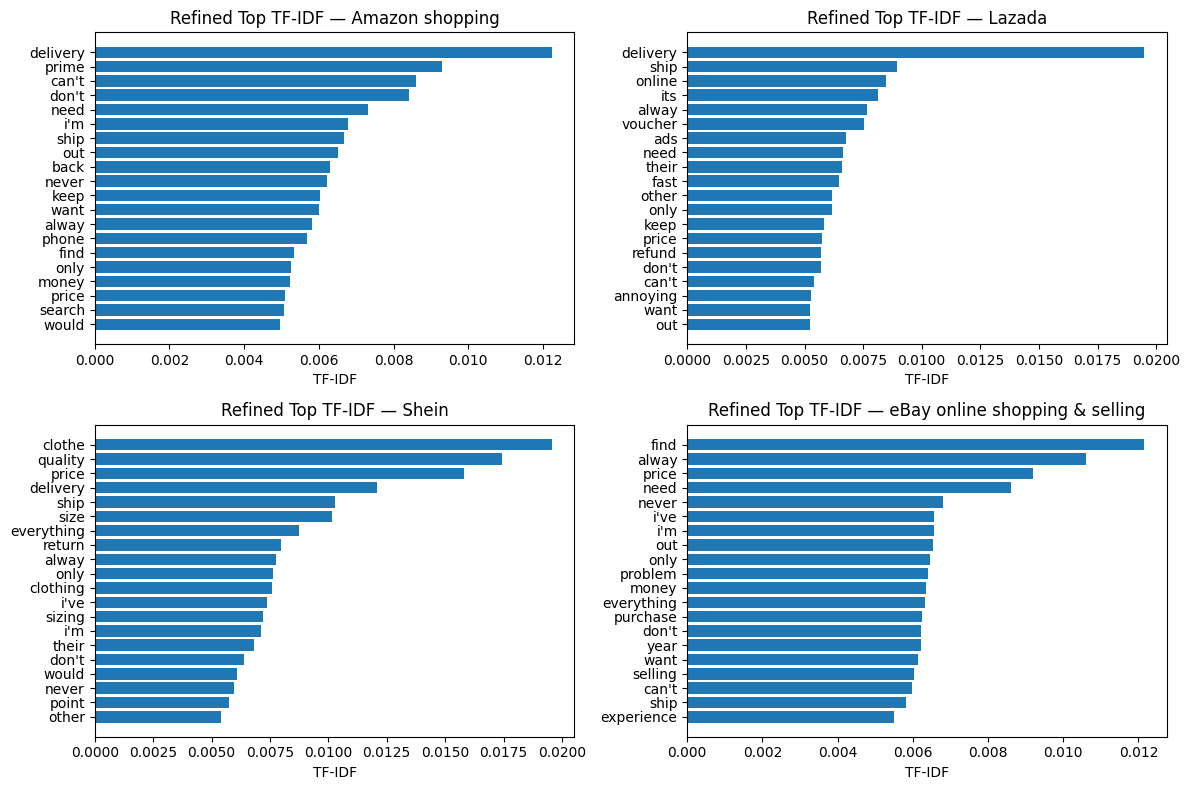

In [19]:
TOPK_TFIDF = 20

tfidf_sorted = tfidf.sort_values(["AppName","tfidf"], ascending=[True, False])
top_tfidf_refined = (
    tfidf_sorted.groupby("AppName", group_keys=False).head(TOPK_TFIDF)
    [["AppName","word","count","tf","idf","tfidf"]]
    .reset_index(drop=True)
)

# 保存
top_tfidf_refined.to_csv(f"{TAB_DIR}/top_tfidf_refined_by_platform.csv", index=False)
print("saved:", f"{TAB_DIR}/top_tfidf_refined_by_platform.csv")

# 画图
import matplotlib.pyplot as plt
apps = top_tfidf_refined["AppName"].unique().tolist()
n = len(apps); ncols = 2; nrows = (n + ncols - 1)//ncols

plt.figure(figsize=(12, 4*nrows))
for i, app in enumerate(apps, 1):
    sub = top_tfidf_refined[top_tfidf_refined["AppName"]==app].sort_values("tfidf")
    plt.subplot(nrows, ncols, i)
    plt.barh(sub["word"], sub["tfidf"])
    plt.title(f"Refined Top TF-IDF — {app}")
    plt.xlabel("TF-IDF")
    plt.tight_layout()

plt.savefig(f"{FIG_DIR}/top_tfidf_refined_by_platform.png", dpi=300, bbox_inches="tight")
plt.show()
